# Summary

This notebook compares the results obtained by running the method in discovery mode with those of the semi-supervised mode.

In [2]:
import sys
sys.path.append("..")

#GPU configuration
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config.log_device_placement = True  # to log device placement (on which device the operation ran)
sess = tf.Session(config=config)
set_session(sess)

import random
import sys
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scripts.data_generator as data_generator
import scripts.feature_ranking as feature_ranking
import scripts.features_2d as features_2d
import scripts.ga as ga
import scripts.main as main
import scripts.semi_supervised as semi_supervised
import scripts.ga_evaluation as ga_evaluation
import tensorflow as tf
from IPython import get_ipython

from tqdm import tqdm
from collections import Counter

from sklearn.metrics.cluster import adjusted_rand_score, silhouette_score
plt.ion()
plt.show()


random_state=4
random.seed( random_state )
np.random.seed(random_state)
method = "adapted_ratkowsky_lance"

%load_ext autoreload
%autoreload 2

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: GeForce RTX 2060, pci bus id: 0000:01:00.0, compute capability: 7.5

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Utils function

In [3]:
def discovery_vs_semisupervised(subspace_size=10):
    n_clusters_per_subpace = [4, 4]
    cluster_std = 0.10
    clustering="gmm"
    method = "adapted_ratkowsky_lance"
    data, best_subspaces, truths = data_generator.make_data_for_ga(
        n_clusters_per_subpace,
        cluster_std=[cluster_std] * len(n_clusters_per_subpace),
        n_uniform_features=300,
        n_normal_features=300,
        n_neg_binomial=0,
        n_gamma=100,
        n_beta=100,
        random_redundant=True,
        n_redundant=1,
        min_subspace_features=subspace_size,
        max_subspace_features=subspace_size + 1,
        max_neg_bin_p=0.3,
        n_samples=1200,
        plot=False)

    truth = truths[0]
    n_clusters = 4
    # Semi-supervised analysis
    meta_features = feature_ranking.rank_features(data,
                                                  nb_bins=20,
                                                  rank_threshold=90,
                                                  z_file=None,
                                                  metric='correlation',
                                                  redundant_threshold=0.3)
    model_file = f'models/gmm_arl.h5'
    population, n = features_2d.run(data,
                                    n_clusters,
                                    meta_features,
                                    model_file=model_file,
                                    add_close_population=False)

    population = population[["feature1", "feature2"]]
    semi_supervised_results = []
    semi_supervised_ari = []
    for i in range(len(best_subspaces)):
        seeds = np.random.choice(best_subspaces[i], size=(3, 2), replace=False)
        for seed in seeds:
            best_subspace = semi_supervised.maximize_subspace(
                seed,
                data,
                truths[i],
                n_clusters,
                meta_features,
                population[:1000],
                sampling=None,
                debug=False,
                allow_subspace_overlap=True,
                method=method,
                clustering=clustering)
            semi_supervised_results.append(best_subspace["features"])
            semi_supervised_ari.append(best_subspace["ari"])

    # Discovery analysis
    sol = main.discovery_analysis(data,
                                  truth,
                                  n_clusters,
                                  nb_top_subspaces=3,
                                  sampling=None,
                                  allow_subspace_overlap=True,
                                  redundant_threshold=0.3,
                                  round_size=4,
                                  metric='correlation',
                                  method=method,
                                  clustering=clustering,
                                  model_file=model_file)

    discovered_subspaces = sol["features"].values
    discovered_ari = []
    for p in sol["partition"].values:
        a1 = adjusted_rand_score(truths[0], p)
        a2 = adjusted_rand_score(truths[1], p)
        discovered_ari.append(max(a1, a2))

    return best_subspaces, discovered_subspaces, semi_supervised_results, discovered_ari, semi_supervised_ari

# Step1 generate and cluster datasets with both methods

In [4]:
subspace_sizes = [10, 30, 60]
results = []

for ss in subspace_sizes:
    subspace_results = []
    for _ in range(5):
        print(".", end = "")
        (true_subspace, discovered_subspace, ssupervised_results,
        ari_d, ari_s) = discovery_vs_semisupervised(
            subspace_size=ss)
        subspace_results.append([true_subspace, discovered_subspace, ssupervised_results, ari_d, ari_s])
    results.append(subspace_results)

np.save("../../data/discovery_vs_semisupervised.npy", results)


.Total: (1200, 821), uniform (1200, 300) , normal (1200, 300),neg bin (1200, 0), gamma (1200, 100), moon (1200, 2), circle (1200, 2),  bimodal (1200, 0), redundat (1200, 1), outliers with uniform (1200, 0), outliers with normal (1200, 0) ,outlier binomial (1200, 0), beta features (1200, 100), 
(821,) (821,)
Statistics computation 0.41 sec
Entropy computation 1.46 sec
KNN computation 0.76 sec
Sorting and thresholds 0.03 sec
Performing clustering from file
Hierarchical clustering 0.38 sec
Handle redundant features 0.02 sec
Done 0.0 sec
Returning 0 redundant features and  17 important features
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


trimming 665 to 410
handle_close_important (410, 3), total 1146
relevant_features 466 => computing 4550 
trimming 3300 to 0
handle_important_features (410, 3),  total 4550
irrelevant_features 355 => computing 1746
trimming 1595 to 410
handle_not_important_features (820, 3), total 1746
handle_all_features 821 => comput

  0%|          | 0/13 [00:00<?, ?it/s]

done predicting
trimming 2537 to 821
handle_all_features (1641, 3),  total 4075
run (1641, 3), total 11517
nb_dims : 821 => d = 50
Non redundant features 821, orig size 821, nb imp : 17
Selecting (50, 4) from archive


 31%|███       | 4/13 [00:37<01:26,  9.57s/it]

S=8, Tabu = 97S=8, Tabu = 194

,adapted_ratkowsky_lance,ari,features,partition,size,structure
0,0.188463,0.0,"[10, 11, 12, 14, 16, 17, 18, 19]","[0, 1, 3, 1, 1, 1, 2, 0, 3, 1, 1, 0, 0, 0, 0, ...",8.0,"Counter({0: 300, 1: 300, 3: 300, 2: 300})"


Selecting (20, 4) from archive


 62%|██████▏   | 8/13 [01:31<00:55, 11.10s/it]

S=8, Tabu = 97S=8, Tabu = 196

,adapted_ratkowsky_lance,ari,features,partition,size,structure
0,0.188463,0.0,"[10, 11, 12, 14, 16, 17, 18, 19]","[0, 1, 3, 1, 1, 1, 2, 0, 3, 1, 1, 0, 0, 0, 0, ...",8.0,"Counter({0: 300, 1: 300, 3: 300, 2: 300})"
1,0.168541,1.0,"[0, 1, 4, 5, 6, 7, 8, 9]","[1, 1, 0, 1, 1, 1, 1, 2, 2, 0, 0, 2, 3, 2, 0, ...",8.0,"Counter({1: 300, 0: 300, 2: 300, 3: 300})"


Selecting (28, 4) from archive


 92%|█████████▏| 12/13 [02:27<00:11, 11.84s/it]

S=5, Tabu = 92S=7, Tabu = 187S=7, Tabu = 284

,adapted_ratkowsky_lance,ari,features,partition,size,structure
0,0.188463,0.0,"[10, 11, 12, 14, 16, 17, 18, 19]","[0, 1, 3, 1, 1, 1, 2, 0, 3, 1, 1, 0, 0, 0, 0, ...",8.0,"Counter({0: 300, 1: 300, 3: 300, 2: 300})"
1,0.168541,1.0,"[0, 1, 4, 5, 6, 7, 8, 9]","[1, 1, 0, 1, 1, 1, 1, 2, 2, 0, 0, 2, 3, 2, 0, ...",8.0,"Counter({1: 300, 0: 300, 2: 300, 3: 300})"
2,0.193410,0.0,"[12, 13, 14, 15, 16, 17, 19]","[0, 1, 3, 1, 1, 1, 2, 0, 3, 1, 1, 0, 0, 0, 0, ...",7.0,"Counter({0: 300, 1: 300, 3: 300, 2: 300})"


Selecting (4, 4) from archive


100%|██████████| 13/13 [03:00<00:00, 13.92s/it]


.Total: (1200, 821), uniform (1200, 300) , normal (1200, 300),neg bin (1200, 0), gamma (1200, 100), moon (1200, 2), circle (1200, 2),  bimodal (1200, 0), redundat (1200, 1), outliers with uniform (1200, 0), outliers with normal (1200, 0) ,outlier binomial (1200, 0), beta features (1200, 100), 
(821,) (821,)
Statistics computation 0.36 sec
Entropy computation 1.49 sec
KNN computation 0.88 sec
Sorting and thresholds 0.03 sec
Performing clustering from file
Hierarchical clustering 0.42 sec
Handle redundant features 0.02 sec
Done 0.0 sec
Returning 0 redundant features and  23 important features
trimming 625 to 410
handle_close_important (410, 3), total 1151
relevant_features 469 => computing 4591 
trimming 3142 to 0
handle_important_features (410, 3),  total 4591
irrelevant_features 352 => computing 1739
trimming 1522 to 410
handle_not_important_features (820, 3), total 1739
handle_all_features 821 => computing 4075
done predicting
trimming 2473 to 821
handle_all_features (1641, 3),  total

  0%|          | 0/13 [00:00<?, ?it/s]

done predicting
trimming 2473 to 821
handle_all_features (1641, 3),  total 4075
run (1641, 3), total 11556
nb_dims : 821 => d = 50
Non redundant features 821, orig size 821, nb imp : 23
Selecting (50, 4) from archive


 31%|███       | 4/13 [00:20<00:48,  5.37s/it]

S=9, Tabu = 94S=10, Tabu = 193S=10, Tabu = 290

,adapted_ratkowsky_lance,ari,features,partition,size,structure
0,0.193387,0.0,"[10, 11, 12, 13, 14, 15, 16, 17, 18, 19]","[0, 1, 3, 1, 1, 1, 2, 0, 3, 1, 1, 0, 0, 0, 0, ...",10.0,"Counter({0: 300, 1: 300, 3: 300, 2: 300})"


Selecting (26, 4) from archive


 62%|██████▏   | 8/13 [01:07<00:40,  8.02s/it]

S=9, Tabu = 96S=9, Tabu = 194

,adapted_ratkowsky_lance,ari,features,partition,size,structure
0,0.193387,0.0,"[10, 11, 12, 13, 14, 15, 16, 17, 18, 19]","[0, 1, 3, 1, 1, 1, 2, 0, 3, 1, 1, 0, 0, 0, 0, ...",10.0,"Counter({0: 300, 1: 300, 3: 300, 2: 300})"
1,0.169278,1.0,"[0, 1, 3, 4, 5, 6, 7, 8, 9]","[3, 3, 0, 3, 3, 3, 3, 2, 2, 0, 0, 2, 1, 2, 0, ...",9.0,"Counter({3: 300, 0: 300, 2: 300, 1: 300})"


Selecting (34, 4) from archive


 92%|█████████▏| 12/13 [01:45<00:07,  7.52s/it]

S=2, Tabu = 96S=2, Tabu = 191

,adapted_ratkowsky_lance,ari,features,partition,size,structure
0,0.193387,0.0,"[10, 11, 12, 13, 14, 15, 16, 17, 18, 19]","[0, 1, 3, 1, 1, 1, 2, 0, 3, 1, 1, 0, 0, 0, 0, ...",10.0,"Counter({0: 300, 1: 300, 3: 300, 2: 300})"
1,0.169278,1.0,"[0, 1, 3, 4, 5, 6, 7, 8, 9]","[3, 3, 0, 3, 3, 3, 3, 2, 2, 0, 0, 2, 1, 2, 0, ...",9.0,"Counter({3: 300, 0: 300, 2: 300, 1: 300})"
2,0.155206,-0.0,"[223, 820]","[3, 2, 0, 0, 0, 3, 3, 3, 3, 0, 3, 2, 1, 1, 0, ...",2.0,"Counter({0: 340, 3: 317, 1: 280, 2: 263})"


Selecting (2, 4) from archive


100%|██████████| 13/13 [01:56<00:00,  8.94s/it]
/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:90: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


.Total: (1200, 821), uniform (1200, 300) , normal (1200, 300),neg bin (1200, 0), gamma (1200, 100), moon (1200, 2), circle (1200, 2),  bimodal (1200, 0), redundat (1200, 1), outliers with uniform (1200, 0), outliers with normal (1200, 0) ,outlier binomial (1200, 0), beta features (1200, 100), 
(821,) (821,)
Statistics computation 0.23 sec
Entropy computation 0.8 sec
KNN computation 0.47 sec
Sorting and thresholds 0.01 sec
Performing clustering from file
Hierarchical clustering 0.23 sec
Handle redundant features 0.01 sec
Done 0.0 sec
Returning 0 redundant features and  16 important features
trimming 670 to 410
handle_close_important (410, 3), total 1150
relevant_features 470 => computing 4594 
trimming 3327 to 0
handle_important_features (410, 3),  total 4594
irrelevant_features 351 => computing 1720
trimming 1552 to 410
handle_not_important_features (820, 3), total 1720
handle_all_features 821 => computing 4075
done predicting
trimming 2514 to 821
handle_all_features (1641, 3),  total 

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:90: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


(821,) (821,)
Statistics computation 0.25 sec
Entropy computation 0.86 sec
KNN computation 0.47 sec
Sorting and thresholds 0.02 sec
Performing clustering from file
Hierarchical clustering 0.24 sec
Handle redundant features 0.01 sec
Done 0.0 sec
Returning 0 redundant features and  16 important features
trimming 670 to 410
handle_close_important (410, 3), total 1150
relevant_features 470 => computing 4594 
trimming 3327 to 0
handle_important_features (410, 3),  total 4594
irrelevant_features 351 => computing 1720
trimming 1552 to 410
handle_not_important_features (820, 3), total 1720
handle_all_features 821 => computing 4075


  0%|          | 0/13 [00:00<?, ?it/s]

done predicting
trimming 2514 to 821
handle_all_features (1641, 3),  total 4075
run (1641, 3), total 11539
nb_dims : 821 => d = 50
Non redundant features 821, orig size 821, nb imp : 16
Selecting (50, 4) from archive


 31%|███       | 4/13 [00:20<00:48,  5.38s/it]

S=9, Tabu = 95S=10, Tabu = 193S=10, Tabu = 289

,adapted_ratkowsky_lance,ari,features,partition,size,structure
0,0.193387,0.0,"[10, 11, 12, 13, 14, 15, 16, 17, 18, 19]","[0, 1, 3, 1, 1, 1, 2, 0, 3, 1, 1, 0, 0, 0, 0, ...",10.0,"Counter({0: 300, 1: 300, 3: 300, 2: 300})"


Selecting (24, 4) from archive


 62%|██████▏   | 8/13 [01:06<00:38,  7.79s/it]

S=8, Tabu = 96S=9, Tabu = 192S=9, Tabu = 290

,adapted_ratkowsky_lance,ari,features,partition,size,structure
0,0.193387,0.0,"[10, 11, 12, 13, 14, 15, 16, 17, 18, 19]","[0, 1, 3, 1, 1, 1, 2, 0, 3, 1, 1, 0, 0, 0, 0, ...",10.0,"Counter({0: 300, 1: 300, 3: 300, 2: 300})"
1,0.169278,1.0,"[0, 1, 3, 4, 5, 6, 7, 8, 9]","[3, 3, 0, 3, 3, 3, 3, 2, 2, 0, 0, 2, 1, 2, 0, ...",9.0,"Counter({3: 300, 0: 300, 2: 300, 1: 300})"


Selecting (29, 4) from archive


 92%|█████████▏| 12/13 [01:51<00:08,  8.17s/it]

S=4, Tabu = 97S=5, Tabu = 192S=6, Tabu = 287S=7, Tabu = 379S=8, Tabu = 464S=8, Tabu = 543

,adapted_ratkowsky_lance,ari,features,partition,size,structure
0,0.193387,0.0,"[10, 11, 12, 13, 14, 15, 16, 17, 18, 19]","[0, 1, 3, 1, 1, 1, 2, 0, 3, 1, 1, 0, 0, 0, 0, ...",10.0,"Counter({0: 300, 1: 300, 3: 300, 2: 300})"
1,0.169278,1.0,"[0, 1, 3, 4, 5, 6, 7, 8, 9]","[3, 3, 0, 3, 3, 3, 3, 2, 2, 0, 0, 2, 1, 2, 0, ...",9.0,"Counter({3: 300, 0: 300, 2: 300, 1: 300})"
2,0.142901,0.0,"[10, 11, 12, 14, 18, 19, 248, 820]","[0, 1, 3, 1, 3, 3, 2, 0, 1, 3, 3, 0, 0, 0, 0, ...",8.0,"Counter({3: 335, 0: 300, 2: 300, 1: 265})"


Selecting (3, 4) from archive


100%|██████████| 13/13 [02:25<00:00, 11.17s/it]
/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:90: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


.Total: (1200, 821), uniform (1200, 300) , normal (1200, 300),neg bin (1200, 0), gamma (1200, 100), moon (1200, 2), circle (1200, 2),  bimodal (1200, 0), redundat (1200, 1), outliers with uniform (1200, 0), outliers with normal (1200, 0) ,outlier binomial (1200, 0), beta features (1200, 100), 
(821,) (821,)
Statistics computation 0.26 sec
Entropy computation 0.82 sec
KNN computation 0.48 sec
Sorting and thresholds 0.02 sec
Performing clustering from file
Hierarchical clustering 0.23 sec
Handle redundant features 0.01 sec
Done 0.0 sec
Returning 0 redundant features and  15 important features
trimming 678 to 410
handle_close_important (410, 3), total 1140
relevant_features 476 => computing 4637 
trimming 3328 to 0
handle_important_features (410, 3),  total 4637
irrelevant_features 345 => computing 1697
trimming 1530 to 410
handle_not_important_features (820, 3), total 1697
handle_all_features 821 => computing 4075
done predicting
trimming 2507 to 821
handle_all_features (1641, 3),  total

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:90: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


(821,) (821,)
Statistics computation 0.27 sec
Entropy computation 0.86 sec
KNN computation 0.5 sec
Sorting and thresholds 0.02 sec
Performing clustering from file
Hierarchical clustering 0.23 sec
Handle redundant features 0.01 sec
Done 0.0 sec
Returning 0 redundant features and  15 important features
trimming 678 to 410
handle_close_important (410, 3), total 1140
relevant_features 476 => computing 4637 
trimming 3328 to 0
handle_important_features (410, 3),  total 4637
irrelevant_features 345 => computing 1697
trimming 1530 to 410
handle_not_important_features (820, 3), total 1697
handle_all_features 821 => computing 4075


  0%|          | 0/13 [00:00<?, ?it/s]

done predicting
trimming 2507 to 821
handle_all_features (1641, 3),  total 4075
run (1641, 3), total 11549
nb_dims : 821 => d = 50
Non redundant features 821, orig size 821, nb imp : 15
Selecting (50, 4) from archive


 31%|███       | 4/13 [00:19<00:45,  5.09s/it]

S=10, Tabu = 96S=10, Tabu = 195

,adapted_ratkowsky_lance,ari,features,partition,size,structure
0,0.193387,0.0,"[10, 11, 12, 13, 14, 15, 16, 17, 18, 19]","[0, 1, 3, 1, 1, 1, 2, 0, 3, 1, 1, 0, 0, 0, 0, ...",10.0,"Counter({0: 300, 1: 300, 3: 300, 2: 300})"


Selecting (22, 4) from archive


 62%|██████▏   | 8/13 [00:58<00:35,  7.17s/it]

S=9, Tabu = 98S=10, Tabu = 193S=10, Tabu = 288

,adapted_ratkowsky_lance,ari,features,partition,size,structure
0,0.193387,0.0,"[10, 11, 12, 13, 14, 15, 16, 17, 18, 19]","[0, 1, 3, 1, 1, 1, 2, 0, 3, 1, 1, 0, 0, 0, 0, ...",10.0,"Counter({0: 300, 1: 300, 3: 300, 2: 300})"
1,0.169964,1.0,"[0, 1, 3, 4, 5, 6, 7, 8, 9, 820]","[3, 3, 0, 3, 3, 3, 3, 2, 2, 0, 0, 2, 1, 2, 0, ...",10.0,"Counter({3: 300, 0: 300, 2: 300, 1: 300})"


Selecting (33, 4) from archive


 92%|█████████▏| 12/13 [01:44<00:08,  8.18s/it]

S=2, Tabu = 99S=2, Tabu = 193

,adapted_ratkowsky_lance,ari,features,partition,size,structure
0,0.193387,0.0,"[10, 11, 12, 13, 14, 15, 16, 17, 18, 19]","[0, 1, 3, 1, 1, 1, 2, 0, 3, 1, 1, 0, 0, 0, 0, ...",10.0,"Counter({0: 300, 1: 300, 3: 300, 2: 300})"
1,0.169964,1.0,"[0, 1, 3, 4, 5, 6, 7, 8, 9, 820]","[3, 3, 0, 3, 3, 3, 3, 2, 2, 0, 0, 2, 1, 2, 0, ...",10.0,"Counter({3: 300, 0: 300, 2: 300, 1: 300})"
2,0.127675,-0.0,"[74, 115]","[0, 2, 2, 1, 2, 1, 3, 1, 3, 2, 1, 2, 0, 0, 1, ...",2.0,"Counter({3: 306, 2: 305, 0: 297, 1: 292})"


Selecting (3, 4) from archive


100%|██████████| 13/13 [01:54<00:00,  8.78s/it]


.Total: (1200, 821), uniform (1200, 300) , normal (1200, 300),neg bin (1200, 0), gamma (1200, 100), moon (1200, 2), circle (1200, 2),  bimodal (1200, 0), redundat (1200, 1), outliers with uniform (1200, 0), outliers with normal (1200, 0) ,outlier binomial (1200, 0), beta features (1200, 100), 
(821,) (821,)
Statistics computation 0.22 sec
Entropy computation 0.82 sec
KNN computation 0.45 sec
Sorting and thresholds 0.01 sec
Performing clustering from file
Hierarchical clustering 0.22 sec
Handle redundant features 0.01 sec
Done 0.0 sec
Returning 0 redundant features and  21 important features
trimming 640 to 410
handle_close_important (410, 3), total 1113
relevant_features 471 => computing 4597 
trimming 3338 to 0
handle_important_features (410, 3),  total 4597
irrelevant_features 350 => computing 1721
trimming 1547 to 410
handle_not_important_features (820, 3), total 1721
handle_all_features 821 => computing 4075
done predicting
trimming 2548 to 821
handle_all_features (1641, 3),  total

  0%|          | 0/13 [00:00<?, ?it/s]

done predicting
trimming 2548 to 821
handle_all_features (1641, 3),  total 4075
run (1641, 3), total 11506
nb_dims : 821 => d = 50
Non redundant features 821, orig size 821, nb imp : 21
Selecting (50, 4) from archive


 31%|███       | 4/13 [00:19<00:45,  5.07s/it]

S=7, Tabu = 98S=7, Tabu = 197

,adapted_ratkowsky_lance,ari,features,partition,size,structure
0,0.18246,0.0,"[10, 11, 13, 14, 15, 18, 19]","[0, 3, 1, 3, 3, 3, 2, 0, 1, 3, 3, 0, 0, 0, 0, ...",7.0,"Counter({0: 300, 3: 300, 1: 300, 2: 300})"


Selecting (17, 4) from archive


 62%|██████▏   | 8/13 [00:51<00:30,  6.09s/it]

S=9, Tabu = 96S=9, Tabu = 196

,adapted_ratkowsky_lance,ari,features,partition,size,structure
0,0.182460,0.0,"[10, 11, 13, 14, 15, 18, 19]","[0, 3, 1, 3, 3, 3, 2, 0, 1, 3, 3, 0, 0, 0, 0, ...",7.0,"Counter({0: 300, 3: 300, 1: 300, 2: 300})"
1,0.169278,1.0,"[0, 1, 3, 4, 5, 6, 7, 8, 9]","[3, 3, 0, 3, 3, 3, 3, 2, 2, 0, 0, 2, 1, 2, 0, ...",9.0,"Counter({3: 300, 0: 300, 2: 300, 1: 300})"


Selecting (29, 4) from archive


 92%|█████████▏| 12/13 [01:27<00:06,  6.89s/it]

S=4, Tabu = 92S=5, Tabu = 190S=8, Tabu = 282S=9, Tabu = 374S=9, Tabu = 458

,adapted_ratkowsky_lance,ari,features,partition,size,structure
0,0.182460,0.0,"[10, 11, 13, 14, 15, 18, 19]","[0, 3, 1, 3, 3, 3, 2, 0, 1, 3, 3, 0, 0, 0, 0, ...",7.0,"Counter({0: 300, 3: 300, 1: 300, 2: 300})"
1,0.169278,1.0,"[0, 1, 3, 4, 5, 6, 7, 8, 9]","[3, 3, 0, 3, 3, 3, 3, 2, 2, 0, 0, 2, 1, 2, 0, ...",9.0,"Counter({3: 300, 0: 300, 2: 300, 1: 300})"
2,0.190996,0.0,"[10, 11, 12, 13, 14, 15, 16, 17, 18]","[0, 3, 2, 3, 3, 3, 1, 0, 2, 3, 3, 0, 0, 0, 0, ...",9.0,"Counter({0: 300, 3: 300, 2: 300, 1: 300})"


Selecting (12, 4) from archive


100%|██████████| 13/13 [01:59<00:00,  9.19s/it]
/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:90: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


.Total: (1200, 861), uniform (1200, 300) , normal (1200, 300),neg bin (1200, 0), gamma (1200, 100), moon (1200, 2), circle (1200, 2),  bimodal (1200, 0), redundat (1200, 1), outliers with uniform (1200, 0), outliers with normal (1200, 0) ,outlier binomial (1200, 0), beta features (1200, 100), 
(861,) (861,)
Statistics computation 0.22 sec
Entropy computation 0.83 sec
KNN computation 0.54 sec
Sorting and thresholds 0.02 sec
Performing clustering from file
Hierarchical clustering 0.25 sec
Handle redundant features 0.02 sec
Done 0.0 sec
Returning 8 redundant features and  19 important features
trimming 725 to 426
handle_close_important (426, 3), total 1192
relevant_features 481 => computing 4702 
trimming 3386 to 8
handle_important_features (434, 3),  total 4702
irrelevant_features 372 => computing 1832
trimming 1628 to 426
handle_not_important_features (860, 3), total 1832
handle_all_features 853 => computing 4235
done predicting
trimming 2730 to 853
handle_all_features (1713, 3),  total

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:90: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


(861,) (861,)
Statistics computation 0.33 sec
Entropy computation 0.95 sec
KNN computation 0.63 sec
Sorting and thresholds 0.02 sec
Performing clustering from file
Hierarchical clustering 0.3 sec
Handle redundant features 0.03 sec
Done 0.0 sec
Returning 8 redundant features and  19 important features
trimming 725 to 426
handle_close_important (426, 3), total 1192
relevant_features 481 => computing 4702 
trimming 3386 to 8
handle_important_features (434, 3),  total 4702
irrelevant_features 372 => computing 1832
trimming 1628 to 426
handle_not_important_features (860, 3), total 1832
handle_all_features 853 => computing 4235


  0%|          | 0/13 [00:00<?, ?it/s]

done predicting
trimming 2730 to 853
handle_all_features (1713, 3),  total 4235
run (1713, 3), total 11961
nb_dims : 861 => d = 50
Non redundant features 853, orig size 861, nb imp : 19
Selecting (50, 4) from archive


 31%|███       | 4/13 [00:25<00:58,  6.48s/it]

S=20, Tabu = 87S=28, Tabu = 178S=28, Tabu = 276

,adapted_ratkowsky_lance,ari,features,partition,size,structure
0,0.202533,-0.0,"[30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 4...","[0, 1, 0, 3, 3, 0, 3, 0, 2, 0, 3, 3, 1, 1, 0, ...",28.0,"Counter({0: 300, 1: 300, 3: 300, 2: 300})"


Selecting (16, 4) from archive


 62%|██████▏   | 8/13 [01:56<01:17, 15.54s/it]

S=27, Tabu = 95S=27, Tabu = 195

,adapted_ratkowsky_lance,ari,features,partition,size,structure
0,0.202533,-0.0,"[30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 4...","[0, 1, 0, 3, 3, 0, 3, 0, 2, 0, 3, 3, 1, 1, 0, ...",28.0,"Counter({0: 300, 1: 300, 3: 300, 2: 300})"
1,0.201018,1.0,"[0, 1, 3, 4, 5, 6, 7, 9, 10, 12, 13, 14, 15, 1...","[3, 0, 2, 1, 0, 0, 1, 1, 3, 0, 0, 1, 3, 0, 2, ...",27.0,"Counter({3: 300, 0: 300, 2: 300, 1: 300})"


Selecting (50, 4) from archive


 92%|█████████▏| 12/13 [02:56<00:11, 11.96s/it]

S=2, Tabu = 98S=2, Tabu = 197

,adapted_ratkowsky_lance,ari,features,partition,size,structure
0,0.202533,-0.0,"[30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 4...","[0, 1, 0, 3, 3, 0, 3, 0, 2, 0, 3, 3, 1, 1, 0, ...",28.0,"Counter({0: 300, 1: 300, 3: 300, 2: 300})"
1,0.201018,1.0,"[0, 1, 3, 4, 5, 6, 7, 9, 10, 12, 13, 14, 15, 1...","[3, 0, 2, 1, 0, 0, 1, 1, 3, 0, 0, 1, 3, 0, 2, ...",27.0,"Counter({3: 300, 0: 300, 2: 300, 1: 300})"
2,0.127717,-0.0,"[108, 293]","[2, 3, 2, 2, 3, 3, 1, 0, 3, 2, 0, 2, 2, 0, 3, ...",2.0,"Counter({0: 316, 2: 307, 3: 297, 1: 280})"


Selecting (2, 4) from archive


100%|██████████| 13/13 [03:08<00:00, 14.48s/it]
/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:90: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


.Total: (1200, 861), uniform (1200, 300) , normal (1200, 300),neg bin (1200, 0), gamma (1200, 100), moon (1200, 2), circle (1200, 2),  bimodal (1200, 0), redundat (1200, 1), outliers with uniform (1200, 0), outliers with normal (1200, 0) ,outlier binomial (1200, 0), beta features (1200, 100), 
(861,) (861,)
Statistics computation 0.28 sec
Entropy computation 0.95 sec
KNN computation 0.6 sec
Sorting and thresholds 0.02 sec
Performing clustering from file
Hierarchical clustering 0.29 sec
Handle redundant features 0.02 sec
Done 0.0 sec
Returning 8 redundant features and  19 important features
trimming 717 to 426
handle_close_important (426, 3), total 1171
relevant_features 481 => computing 4702 
trimming 3424 to 8
handle_important_features (434, 3),  total 4702
irrelevant_features 372 => computing 1832
trimming 1606 to 426
handle_not_important_features (860, 3), total 1832
handle_all_features 853 => computing 4235
done predicting
trimming 2671 to 853
handle_all_features (1713, 3),  total 

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:90: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


(861,) (861,)
Statistics computation 0.31 sec
Entropy computation 0.92 sec
KNN computation 0.59 sec
Sorting and thresholds 0.02 sec
Performing clustering from file
Hierarchical clustering 0.28 sec
Handle redundant features 0.02 sec
Done 0.0 sec
Returning 8 redundant features and  19 important features
trimming 717 to 426
handle_close_important (426, 3), total 1171
relevant_features 481 => computing 4702 
trimming 3424 to 8
handle_important_features (434, 3),  total 4702
irrelevant_features 372 => computing 1832
trimming 1606 to 426
handle_not_important_features (860, 3), total 1832
handle_all_features 853 => computing 4235


  0%|          | 0/13 [00:00<?, ?it/s]

done predicting
trimming 2671 to 853
handle_all_features (1713, 3),  total 4235
run (1713, 3), total 11940
nb_dims : 861 => d = 50
Non redundant features 853, orig size 861, nb imp : 19
Selecting (50, 4) from archive


 31%|███       | 4/13 [00:24<00:56,  6.31s/it]

S=23, Tabu = 87S=26, Tabu = 181S=29, Tabu = 273S=29, Tabu = 369

,adapted_ratkowsky_lance,ari,features,partition,size,structure
0,0.196485,1.0,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14,...","[3, 0, 2, 1, 0, 0, 1, 1, 3, 0, 0, 1, 3, 0, 2, ...",29.0,"Counter({3: 300, 0: 300, 2: 300, 1: 300})"


Selecting (31, 4) from archive


 62%|██████▏   | 8/13 [02:02<01:17, 15.56s/it]

S=26, Tabu = 88S=28, Tabu = 185S=28, Tabu = 285

,adapted_ratkowsky_lance,ari,features,partition,size,structure
0,0.196485,1.0,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14,...","[3, 0, 2, 1, 0, 0, 1, 1, 3, 0, 0, 1, 3, 0, 2, ...",29.0,"Counter({3: 300, 0: 300, 2: 300, 1: 300})"
1,0.202886,-0.0,"[31, 32, 34, 35, 36, 37, 38, 40, 41, 42, 43, 4...","[0, 2, 0, 1, 1, 0, 1, 0, 3, 0, 1, 1, 2, 2, 0, ...",28.0,"Counter({0: 300, 2: 300, 1: 300, 3: 300})"


Selecting (50, 4) from archive


 92%|█████████▏| 12/13 [03:16<00:13, 13.34s/it]

S=2, Tabu = 99S=2, Tabu = 198

,adapted_ratkowsky_lance,ari,features,partition,size,structure
0,0.196485,1.0,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14,...","[3, 0, 2, 1, 0, 0, 1, 1, 3, 0, 0, 1, 3, 0, 2, ...",29.0,"Counter({3: 300, 0: 300, 2: 300, 1: 300})"
1,0.202886,-0.0,"[31, 32, 34, 35, 36, 37, 38, 40, 41, 42, 43, 4...","[0, 2, 0, 1, 1, 0, 1, 0, 3, 0, 1, 1, 2, 2, 0, ...",28.0,"Counter({0: 300, 2: 300, 1: 300, 3: 300})"
2,0.127619,0.0,"[178, 288]","[2, 2, 3, 0, 1, 3, 2, 1, 1, 3, 3, 2, 3, 2, 1, ...",2.0,"Counter({2: 319, 1: 313, 3: 288, 0: 280})"


Selecting (4, 4) from archive


100%|██████████| 13/13 [03:28<00:00, 16.01s/it]
/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:90: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


.Total: (1200, 861), uniform (1200, 300) , normal (1200, 300),neg bin (1200, 0), gamma (1200, 100), moon (1200, 2), circle (1200, 2),  bimodal (1200, 0), redundat (1200, 1), outliers with uniform (1200, 0), outliers with normal (1200, 0) ,outlier binomial (1200, 0), beta features (1200, 100), 
(861,) (861,)
Statistics computation 0.31 sec
Entropy computation 0.92 sec
KNN computation 0.59 sec
Sorting and thresholds 0.02 sec
Performing clustering from file
Hierarchical clustering 0.31 sec
Handle redundant features 0.02 sec
Done 0.0 sec
Returning 8 redundant features and  21 important features
trimming 739 to 426
handle_close_important (426, 3), total 1190
relevant_features 483 => computing 4719 
trimming 3309 to 8
handle_important_features (434, 3),  total 4719
irrelevant_features 370 => computing 1825
trimming 1618 to 426
handle_not_important_features (860, 3), total 1825
handle_all_features 853 => computing 4235
done predicting
trimming 2698 to 853
handle_all_features (1713, 3),  total

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:90: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


(861,) (861,)
Statistics computation 0.27 sec
Entropy computation 0.98 sec
KNN computation 0.62 sec
Sorting and thresholds 0.02 sec
Performing clustering from file
Hierarchical clustering 0.3 sec
Handle redundant features 0.02 sec
Done 0.0 sec
Returning 8 redundant features and  21 important features
trimming 739 to 426
handle_close_important (426, 3), total 1190
relevant_features 483 => computing 4719 
trimming 3309 to 8
handle_important_features (434, 3),  total 4719
irrelevant_features 370 => computing 1825
trimming 1618 to 426
handle_not_important_features (860, 3), total 1825
handle_all_features 853 => computing 4235


  0%|          | 0/13 [00:00<?, ?it/s]

done predicting
trimming 2698 to 853
handle_all_features (1713, 3),  total 4235
run (1713, 3), total 11969
nb_dims : 861 => d = 50
Non redundant features 853, orig size 861, nb imp : 21
Selecting (50, 4) from archive


 31%|███       | 4/13 [00:23<00:55,  6.19s/it]

S=24, Tabu = 86S=29, Tabu = 180S=29, Tabu = 278

,adapted_ratkowsky_lance,ari,features,partition,size,structure
0,0.19426,1.0,"[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 12, 13, 14, 15...","[3, 0, 2, 1, 0, 0, 1, 1, 3, 0, 0, 1, 3, 0, 2, ...",29.0,"Counter({3: 300, 0: 300, 2: 300, 1: 300})"


Selecting (28, 4) from archive


 62%|██████▏   | 8/13 [01:50<01:12, 14.57s/it]

S=28, Tabu = 87S=28, Tabu = 186

,adapted_ratkowsky_lance,ari,features,partition,size,structure
0,0.194260,1.0,"[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 12, 13, 14, 15...","[3, 0, 2, 1, 0, 0, 1, 1, 3, 0, 0, 1, 3, 0, 2, ...",29.0,"Counter({3: 300, 0: 300, 2: 300, 1: 300})"
1,0.202897,-0.0,"[31, 32, 34, 35, 36, 37, 38, 40, 41, 42, 43, 4...","[0, 2, 0, 1, 1, 0, 1, 0, 3, 0, 1, 1, 2, 2, 0, ...",28.0,"Counter({0: 300, 2: 300, 1: 300, 3: 300})"


Selecting (50, 4) from archive


 92%|█████████▏| 12/13 [02:45<00:10, 10.97s/it]

S=2, Tabu = 98S=2, Tabu = 195

,adapted_ratkowsky_lance,ari,features,partition,size,structure
0,0.194260,1.0,"[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 12, 13, 14, 15...","[3, 0, 2, 1, 0, 0, 1, 1, 3, 0, 0, 1, 3, 0, 2, ...",29.0,"Counter({3: 300, 0: 300, 2: 300, 1: 300})"
1,0.202897,-0.0,"[31, 32, 34, 35, 36, 37, 38, 40, 41, 42, 43, 4...","[0, 2, 0, 1, 1, 0, 1, 0, 3, 0, 1, 1, 2, 2, 0, ...",28.0,"Counter({0: 300, 2: 300, 1: 300, 3: 300})"
2,0.128583,-0.0,"[213, 848]","[2, 2, 3, 2, 1, 0, 3, 3, 1, 2, 1, 3, 0, 2, 1, ...",2.0,"Counter({3: 349, 0: 339, 1: 266, 2: 246})"


Selecting (3, 4) from archive


100%|██████████| 13/13 [02:56<00:00, 13.57s/it]
/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:90: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


.Total: (1200, 861), uniform (1200, 300) , normal (1200, 300),neg bin (1200, 0), gamma (1200, 100), moon (1200, 2), circle (1200, 2),  bimodal (1200, 0), redundat (1200, 1), outliers with uniform (1200, 0), outliers with normal (1200, 0) ,outlier binomial (1200, 0), beta features (1200, 100), 
(861,) (861,)
Statistics computation 0.27 sec
Entropy computation 0.83 sec
KNN computation 0.52 sec
Sorting and thresholds 0.02 sec
Performing clustering from file
Hierarchical clustering 0.26 sec
Handle redundant features 0.02 sec
Done 0.0 sec
Returning 8 redundant features and  18 important features
trimming 720 to 426
handle_close_important (426, 3), total 1191
relevant_features 484 => computing 4738 
trimming 3415 to 8
handle_important_features (434, 3),  total 4738
irrelevant_features 369 => computing 1814
trimming 1544 to 426
handle_not_important_features (860, 3), total 1814
handle_all_features 853 => computing 4235
done predicting
trimming 2695 to 853
handle_all_features (1713, 3),  total

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:90: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


(861,) (861,)
Statistics computation 0.18 sec
Entropy computation 0.8 sec
KNN computation 0.5 sec
Sorting and thresholds 0.01 sec
Performing clustering from file
Hierarchical clustering 0.22 sec
Handle redundant features 0.02 sec
Done 0.0 sec
Returning 8 redundant features and  18 important features
trimming 720 to 426
handle_close_important (426, 3), total 1191
relevant_features 484 => computing 4738 
trimming 3415 to 8
handle_important_features (434, 3),  total 4738
irrelevant_features 369 => computing 1814
trimming 1544 to 426
handle_not_important_features (860, 3), total 1814
handle_all_features 853 => computing 4235


  0%|          | 0/13 [00:00<?, ?it/s]

done predicting
trimming 2695 to 853
handle_all_features (1713, 3),  total 4235
run (1713, 3), total 11978
nb_dims : 861 => d = 50
Non redundant features 853, orig size 861, nb imp : 18
Selecting (50, 4) from archive


 31%|███       | 4/13 [00:21<00:49,  5.50s/it]

S=23, Tabu = 87S=28, Tabu = 181S=29, Tabu = 279S=29, Tabu = 378

,adapted_ratkowsky_lance,ari,features,partition,size,structure
0,0.198446,1.0,"[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14...","[3, 0, 2, 1, 0, 0, 1, 1, 3, 0, 0, 1, 3, 0, 2, ...",29.0,"Counter({3: 300, 0: 300, 2: 300, 1: 300})"


Selecting (44, 4) from archive


 62%|██████▏   | 8/13 [01:44<01:01, 12.22s/it]

S=29, Tabu = 82S=29, Tabu = 182

,adapted_ratkowsky_lance,ari,features,partition,size,structure
0,0.198446,1.0,"[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14...","[3, 0, 2, 1, 0, 0, 1, 1, 3, 0, 0, 1, 3, 0, 2, ...",29.0,"Counter({3: 300, 0: 300, 2: 300, 1: 300})"
1,0.199459,-0.0,"[31, 32, 34, 35, 36, 37, 38, 39, 40, 41, 42, 4...","[0, 2, 0, 1, 1, 0, 1, 0, 3, 0, 1, 1, 2, 2, 0, ...",29.0,"Counter({0: 300, 2: 300, 1: 300, 3: 300})"


Selecting (50, 4) from archive


 92%|█████████▏| 12/13 [02:35<00:09,  9.78s/it]

S=3, Tabu = 97S=5, Tabu = 188S=5, Tabu = 285

,adapted_ratkowsky_lance,ari,features,partition,size,structure
0,0.198446,1.0,"[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14...","[3, 0, 2, 1, 0, 0, 1, 1, 3, 0, 0, 1, 3, 0, 2, ...",29.0,"Counter({3: 300, 0: 300, 2: 300, 1: 300})"
1,0.199459,-0.0,"[31, 32, 34, 35, 36, 37, 38, 39, 40, 41, 42, 4...","[0, 2, 0, 1, 1, 0, 1, 0, 3, 0, 1, 1, 2, 2, 0, ...",29.0,"Counter({0: 300, 2: 300, 1: 300, 3: 300})"
2,0.156692,-0.0,"[48, 49, 57, 444, 860]","[2, 0, 2, 3, 3, 2, 1, 0, 1, 2, 1, 1, 0, 2, 0, ...",5.0,"Counter({0: 366, 1: 317, 3: 283, 2: 234})"


Selecting (1, 4) from archive


100%|██████████| 13/13 [02:49<00:00, 13.02s/it]
/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:90: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


.Total: (1200, 861), uniform (1200, 300) , normal (1200, 300),neg bin (1200, 0), gamma (1200, 100), moon (1200, 2), circle (1200, 2),  bimodal (1200, 0), redundat (1200, 1), outliers with uniform (1200, 0), outliers with normal (1200, 0) ,outlier binomial (1200, 0), beta features (1200, 100), 
(861,) (861,)
Statistics computation 0.17 sec
Entropy computation 0.77 sec
KNN computation 0.42 sec
Sorting and thresholds 0.01 sec
Performing clustering from file
Hierarchical clustering 0.22 sec
Handle redundant features 0.02 sec
Done 0.0 sec
Returning 8 redundant features and  21 important features
trimming 738 to 426
handle_close_important (426, 3), total 1170
relevant_features 478 => computing 4674 
trimming 3346 to 8
handle_important_features (434, 3),  total 4674
irrelevant_features 375 => computing 1855
trimming 1661 to 426
handle_not_important_features (860, 3), total 1855
handle_all_features 853 => computing 4235
done predicting
trimming 2781 to 853
handle_all_features (1713, 3),  total

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:90: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


(861,) (861,)
Statistics computation 0.17 sec
Entropy computation 0.77 sec
KNN computation 0.44 sec
Sorting and thresholds 0.01 sec
Performing clustering from file
Hierarchical clustering 0.22 sec
Handle redundant features 0.02 sec
Done 0.0 sec
Returning 8 redundant features and  21 important features
trimming 738 to 426
handle_close_important (426, 3), total 1170
relevant_features 478 => computing 4674 
trimming 3346 to 8
handle_important_features (434, 3),  total 4674
irrelevant_features 375 => computing 1855
trimming 1661 to 426
handle_not_important_features (860, 3), total 1855
handle_all_features 853 => computing 4235


  0%|          | 0/13 [00:00<?, ?it/s]

done predicting
trimming 2781 to 853
handle_all_features (1713, 3),  total 4235
run (1713, 3), total 11934
nb_dims : 861 => d = 50
Non redundant features 853, orig size 861, nb imp : 21
Selecting (50, 4) from archive


 31%|███       | 4/13 [00:21<00:49,  5.50s/it]

S=29, Tabu = 80S=30, Tabu = 176S=30, Tabu = 276

,adapted_ratkowsky_lance,ari,features,partition,size,structure
0,0.199551,-0.0,"[30, 31, 32, 33, 34, 35, 36, 37, 38, 40, 41, 4...","[0, 2, 0, 1, 1, 0, 1, 0, 3, 0, 1, 1, 2, 2, 0, ...",30.0,"Counter({0: 300, 2: 300, 1: 300, 3: 300})"


Selecting (30, 4) from archive


 62%|██████▏   | 8/13 [01:44<01:08, 13.77s/it]

S=24, Tabu = 88S=27, Tabu = 183S=28, Tabu = 281S=29, Tabu = 376S=29, Tabu = 471

,adapted_ratkowsky_lance,ari,features,partition,size,structure
0,0.199551,-0.0,"[30, 31, 32, 33, 34, 35, 36, 37, 38, 40, 41, 4...","[0, 2, 0, 1, 1, 0, 1, 0, 3, 0, 1, 1, 2, 2, 0, ...",30.0,"Counter({0: 300, 2: 300, 1: 300, 3: 300})"
1,0.198446,1.0,"[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14...","[3, 0, 2, 1, 0, 0, 1, 1, 3, 0, 0, 1, 3, 0, 2, ...",29.0,"Counter({3: 300, 0: 300, 2: 300, 1: 300})"


Selecting (50, 4) from archive


 92%|█████████▏| 12/13 [03:20<00:14, 14.78s/it]

S=2, Tabu = 99S=2, Tabu = 197

,adapted_ratkowsky_lance,ari,features,partition,size,structure
0,0.199551,-0.0,"[30, 31, 32, 33, 34, 35, 36, 37, 38, 40, 41, 4...","[0, 2, 0, 1, 1, 0, 1, 0, 3, 0, 1, 1, 2, 2, 0, ...",30.0,"Counter({0: 300, 2: 300, 1: 300, 3: 300})"
1,0.198446,1.0,"[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14...","[3, 0, 2, 1, 0, 0, 1, 1, 3, 0, 0, 1, 3, 0, 2, ...",29.0,"Counter({3: 300, 0: 300, 2: 300, 1: 300})"
2,0.128478,-0.0,"[99, 205]","[3, 2, 0, 2, 0, 1, 0, 0, 3, 0, 2, 3, 2, 1, 3, ...",2.0,"Counter({0: 322, 3: 305, 2: 291, 1: 282})"


Selecting (1, 4) from archive


100%|██████████| 13/13 [03:29<00:00, 16.11s/it]
/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:90: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


.Total: (1200, 921), uniform (1200, 300) , normal (1200, 300),neg bin (1200, 0), gamma (1200, 100), moon (1200, 2), circle (1200, 2),  bimodal (1200, 0), redundat (1200, 1), outliers with uniform (1200, 0), outliers with normal (1200, 0) ,outlier binomial (1200, 0), beta features (1200, 100), 
(921,) (921,)
Statistics computation 0.21 sec
Entropy computation 0.83 sec
KNN computation 0.52 sec
Sorting and thresholds 0.01 sec
Performing clustering from file
Hierarchical clustering 0.25 sec
Handle redundant features 0.04 sec
Done 0.0 sec
Returning 33 redundant features and  20 important features
trimming 758 to 444
handle_close_important (444, 3), total 1229
relevant_features 506 => computing 4947 
trimming 3528 to 33
handle_important_features (477, 3),  total 4947
irrelevant_features 382 => computing 1875
trimming 1614 to 444
handle_not_important_features (921, 3), total 1875
handle_all_features 888 => computing 4416
done predicting
trimming 2908 to 888
handle_all_features (1809, 3),  tot

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:90: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


(921,) (921,)
Statistics computation 0.22 sec
Entropy computation 0.84 sec
KNN computation 0.5 sec
Sorting and thresholds 0.01 sec
Performing clustering from file
Hierarchical clustering 0.25 sec
Handle redundant features 0.04 sec
Done 0.0 sec
Returning 33 redundant features and  20 important features
trimming 758 to 444
handle_close_important (444, 3), total 1229
relevant_features 506 => computing 4947 
trimming 3528 to 33
handle_important_features (477, 3),  total 4947
irrelevant_features 382 => computing 1875
trimming 1614 to 444
handle_not_important_features (921, 3), total 1875
handle_all_features 888 => computing 4416


  0%|          | 0/13 [00:00<?, ?it/s]

done predicting
trimming 2908 to 888
handle_all_features (1809, 3),  total 4416
run (1809, 3), total 12467
nb_dims : 921 => d = 50
Non redundant features 888, orig size 921, nb imp : 20
Selecting (50, 4) from archive


 31%|███       | 4/13 [00:22<00:52,  5.81s/it]

S=31, Tabu = 77S=48, Tabu = 159S=50, Tabu = 256S=57, Tabu = 347S=57, Tabu = 442

,adapted_ratkowsky_lance,ari,features,partition,size,structure
0,0.205666,-0.0,"[60, 61, 62, 64, 65, 66, 67, 68, 69, 70, 71, 7...","[0, 2, 1, 0, 0, 1, 0, 0, 0, 0, 1, 3, 0, 3, 1, ...",57.0,"Counter({0: 300, 2: 300, 1: 300, 3: 300})"


Selecting (45, 4) from archive


 62%|██████▏   | 8/13 [02:47<01:36, 19.27s/it]

S=31, Tabu = 83S=41, Tabu = 173S=43, Tabu = 270S=51, Tabu = 359S=53, Tabu = 456S=53, Tabu = 554

,adapted_ratkowsky_lance,ari,features,partition,size,structure
0,0.205666,-0.0,"[60, 61, 62, 64, 65, 66, 67, 68, 69, 70, 71, 7...","[0, 2, 1, 0, 0, 1, 0, 0, 0, 0, 1, 3, 0, 3, 1, ...",57.0,"Counter({0: 300, 2: 300, 1: 300, 3: 300})"
1,0.199266,1.0,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 12, 13, 14, 15...","[1, 3, 1, 1, 3, 2, 2, 1, 3, 2, 2, 3, 2, 3, 1, ...",53.0,"Counter({1: 300, 3: 300, 2: 300, 0: 300})"


Selecting (50, 4) from archive


 92%|█████████▏| 12/13 [05:10<00:20, 20.81s/it]

S=3, Tabu = 97S=5, Tabu = 191S=5, Tabu = 290

,adapted_ratkowsky_lance,ari,features,partition,size,structure
0,0.205666,-0.00,"[60, 61, 62, 64, 65, 66, 67, 68, 69, 70, 71, 7...","[0, 2, 1, 0, 0, 1, 0, 0, 0, 0, 1, 3, 0, 3, 1, ...",57.0,"Counter({0: 300, 2: 300, 1: 300, 3: 300})"
1,0.199266,1.00,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 12, 13, 14, 15...","[1, 3, 1, 1, 3, 2, 2, 1, 3, 2, 2, 3, 2, 3, 1, ...",53.0,"Counter({1: 300, 3: 300, 2: 300, 0: 300})"
2,0.166468,0.23,"[14, 29, 43, 331, 920]","[0, 3, 0, 0, 1, 0, 2, 0, 1, 0, 2, 3, 2, 1, 2, ...",5.0,"Counter({2: 462, 0: 438, 3: 170, 1: 130})"


Selecting (1, 4) from archive


100%|██████████| 13/13 [05:23<00:00, 24.89s/it]
/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:90: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


.Total: (1200, 921), uniform (1200, 300) , normal (1200, 300),neg bin (1200, 0), gamma (1200, 100), moon (1200, 2), circle (1200, 2),  bimodal (1200, 0), redundat (1200, 1), outliers with uniform (1200, 0), outliers with normal (1200, 0) ,outlier binomial (1200, 0), beta features (1200, 100), 
(921,) (921,)
Statistics computation 0.23 sec
Entropy computation 0.8 sec
KNN computation 0.52 sec
Sorting and thresholds 0.01 sec
Performing clustering from file
Hierarchical clustering 0.25 sec
Handle redundant features 0.04 sec
Done 0.0 sec
Returning 33 redundant features and  20 important features
trimming 803 to 444
handle_close_important (444, 3), total 1259
relevant_features 502 => computing 4920 
trimming 3712 to 33
handle_important_features (477, 3),  total 4920
irrelevant_features 386 => computing 1914
trimming 1736 to 444
handle_not_important_features (921, 3), total 1914
handle_all_features 888 => computing 4416
done predicting
trimming 3018 to 888
handle_all_features (1809, 3),  tota

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:90: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


(921,) (921,)
Statistics computation 0.21 sec
Entropy computation 0.84 sec
KNN computation 0.5 sec
Sorting and thresholds 0.01 sec
Performing clustering from file
Hierarchical clustering 0.24 sec
Handle redundant features 0.04 sec
Done 0.0 sec
Returning 33 redundant features and  20 important features
trimming 803 to 444
handle_close_important (444, 3), total 1259
relevant_features 502 => computing 4920 
trimming 3712 to 33
handle_important_features (477, 3),  total 4920
irrelevant_features 386 => computing 1914
trimming 1736 to 444
handle_not_important_features (921, 3), total 1914
handle_all_features 888 => computing 4416


  0%|          | 0/13 [00:00<?, ?it/s]

done predicting
trimming 3018 to 888
handle_all_features (1809, 3),  total 4416
run (1809, 3), total 12509
nb_dims : 921 => d = 50
Non redundant features 888, orig size 921, nb imp : 20
Selecting (50, 4) from archive


 31%|███       | 4/13 [00:21<00:50,  5.57s/it]

S=28, Tabu = 80S=50, Tabu = 156S=56, Tabu = 250S=57, Tabu = 348S=58, Tabu = 446S=58, Tabu = 543

,adapted_ratkowsky_lance,ari,features,partition,size,structure
0,0.207051,-0.0,"[60, 61, 62, 63, 64, 66, 67, 68, 69, 70, 71, 7...","[0, 3, 2, 0, 0, 2, 0, 0, 0, 0, 2, 1, 0, 1, 2, ...",58.0,"Counter({0: 300, 3: 300, 2: 300, 1: 300})"


Selecting (37, 4) from archive


 62%|██████▏   | 8/13 [03:33<02:05, 25.12s/it]

S=34, Tabu = 84S=46, Tabu = 169S=49, Tabu = 266S=52, Tabu = 362S=52, Tabu = 461

,adapted_ratkowsky_lance,ari,features,partition,size,structure
0,0.207051,-0.0,"[60, 61, 62, 63, 64, 66, 67, 68, 69, 70, 71, 7...","[0, 3, 2, 0, 0, 2, 0, 0, 0, 0, 2, 1, 0, 1, 2, ...",58.0,"Counter({0: 300, 3: 300, 2: 300, 1: 300})"
1,0.204501,1.0,"[1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 1...","[3, 1, 3, 3, 1, 2, 2, 3, 1, 2, 2, 1, 2, 1, 3, ...",52.0,"Counter({3: 300, 1: 300, 2: 300, 0: 300})"


Selecting (50, 4) from archive


 92%|█████████▏| 12/13 [05:38<00:20, 20.49s/it]

S=7, Tabu = 93S=17, Tabu = 182S=35, Tabu = 262S=43, Tabu = 352S=46, Tabu = 447S=46, Tabu = 544

,adapted_ratkowsky_lance,ari,features,partition,size,structure
0,0.207051,-0.0,"[60, 61, 62, 63, 64, 66, 67, 68, 69, 70, 71, 7...","[0, 3, 2, 0, 0, 2, 0, 0, 0, 0, 2, 1, 0, 1, 2, ...",58.0,"Counter({0: 300, 3: 300, 2: 300, 1: 300})"
1,0.204501,1.0,"[1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 1...","[3, 1, 3, 3, 1, 2, 2, 3, 1, 2, 2, 1, 2, 1, 3, ...",52.0,"Counter({3: 300, 1: 300, 2: 300, 0: 300})"
2,0.202170,-0.0,"[60, 62, 63, 64, 66, 67, 68, 69, 71, 72, 73, 7...","[0, 3, 2, 0, 0, 2, 0, 0, 0, 0, 2, 1, 0, 1, 2, ...",46.0,"Counter({0: 300, 3: 300, 2: 300, 1: 300})"


Selecting (7, 4) from archive


100%|██████████| 13/13 [07:18<00:00, 33.70s/it]


.Total: (1200, 921), uniform (1200, 300) , normal (1200, 300),neg bin (1200, 0), gamma (1200, 100), moon (1200, 2), circle (1200, 2),  bimodal (1200, 0), redundat (1200, 1), outliers with uniform (1200, 0), outliers with normal (1200, 0) ,outlier binomial (1200, 0), beta features (1200, 100), 
(921,) (921,)
Statistics computation 0.18 sec
Entropy computation 0.81 sec
KNN computation 0.49 sec
Sorting and thresholds 0.01 sec
Performing clustering from file
Hierarchical clustering 0.24 sec
Handle redundant features 0.04 sec
Done 0.0 sec
Returning 33 redundant features and  20 important features
trimming 785 to 444
handle_close_important (444, 3), total 1246
relevant_features 507 => computing 4975 
trimming 3631 to 33
handle_important_features (477, 3),  total 4975
irrelevant_features 381 => computing 1874
trimming 1660 to 444
handle_not_important_features (921, 3), total 1874
handle_all_features 888 => computing 4416
done predicting
trimming 2968 to 888
handle_all_features (1809, 3),  tot

  0%|          | 0/13 [00:00<?, ?it/s]

done predicting
trimming 2968 to 888
handle_all_features (1809, 3),  total 4416
run (1809, 3), total 12511
nb_dims : 921 => d = 50
Non redundant features 888, orig size 921, nb imp : 20
Selecting (50, 4) from archive


 31%|███       | 4/13 [00:22<00:51,  5.67s/it]

S=40, Tabu = 70S=55, Tabu = 154S=57, Tabu = 251S=57, Tabu = 350

,adapted_ratkowsky_lance,ari,features,partition,size,structure
0,0.207516,-0.0,"[60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 7...","[0, 1, 3, 0, 0, 3, 0, 0, 0, 0, 3, 2, 0, 2, 3, ...",57.0,"Counter({0: 300, 1: 300, 3: 300, 2: 300})"


Selecting (42, 4) from archive


 62%|██████▏   | 8/13 [02:42<01:39, 19.88s/it]

S=43, Tabu = 71S=49, Tabu = 163S=50, Tabu = 259S=51, Tabu = 354S=51, Tabu = 452

,adapted_ratkowsky_lance,ari,features,partition,size,structure
0,0.207516,-0.0,"[60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 7...","[0, 1, 3, 0, 0, 3, 0, 0, 0, 0, 3, 2, 0, 2, 3, ...",57.0,"Counter({0: 300, 1: 300, 3: 300, 2: 300})"
1,0.202444,1.0,"[0, 1, 2, 3, 4, 6, 7, 10, 11, 12, 13, 14, 15, ...","[1, 2, 1, 1, 2, 3, 3, 1, 2, 3, 3, 2, 3, 2, 1, ...",51.0,"Counter({1: 300, 2: 300, 3: 300, 0: 300})"


Selecting (50, 4) from archive


 92%|█████████▏| 12/13 [04:47<00:19, 19.29s/it]

S=21, Tabu = 81S=47, Tabu = 152S=56, Tabu = 238S=56, Tabu = 336

,adapted_ratkowsky_lance,ari,features,partition,size,structure
0,0.207516,-0.0,"[60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 7...","[0, 1, 3, 0, 0, 3, 0, 0, 0, 0, 3, 2, 0, 2, 3, ...",57.0,"Counter({0: 300, 1: 300, 3: 300, 2: 300})"
1,0.202444,1.0,"[0, 1, 2, 3, 4, 6, 7, 10, 11, 12, 13, 14, 15, ...","[1, 2, 1, 1, 2, 3, 3, 1, 2, 3, 3, 2, 3, 2, 1, ...",51.0,"Counter({1: 300, 2: 300, 3: 300, 0: 300})"
2,0.208923,-0.0,"[60, 61, 62, 64, 65, 66, 67, 68, 69, 70, 71, 7...","[0, 3, 2, 0, 0, 2, 0, 0, 0, 0, 2, 1, 0, 1, 2, ...",56.0,"Counter({0: 300, 3: 300, 2: 300, 1: 300})"


Selecting (9, 4) from archive


100%|██████████| 13/13 [06:18<00:00, 29.11s/it]
/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:90: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


.Total: (1200, 921), uniform (1200, 300) , normal (1200, 300),neg bin (1200, 0), gamma (1200, 100), moon (1200, 2), circle (1200, 2),  bimodal (1200, 0), redundat (1200, 1), outliers with uniform (1200, 0), outliers with normal (1200, 0) ,outlier binomial (1200, 0), beta features (1200, 100), 
(921,) (921,)
Statistics computation 0.2 sec
Entropy computation 0.84 sec
KNN computation 0.51 sec
Sorting and thresholds 0.01 sec
Performing clustering from file
Hierarchical clustering 0.25 sec
Handle redundant features 0.04 sec
Done 0.0 sec
Returning 34 redundant features and  22 important features
trimming 784 to 443
handle_close_important (443, 3), total 1245
relevant_features 507 => computing 4975 
trimming 3692 to 34
handle_important_features (477, 3),  total 4975
irrelevant_features 380 => computing 1866
trimming 1716 to 443
handle_not_important_features (920, 3), total 1866
handle_all_features 887 => computing 4407
done predicting
trimming 2933 to 887
handle_all_features (1807, 3),  tota

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:90: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


(921,) (921,)
Statistics computation 0.21 sec
Entropy computation 0.82 sec
KNN computation 0.49 sec
Sorting and thresholds 0.01 sec
Performing clustering from file
Hierarchical clustering 0.25 sec
Handle redundant features 0.03 sec
Done 0.0 sec
Returning 34 redundant features and  22 important features
trimming 784 to 443
handle_close_important (443, 3), total 1245
relevant_features 507 => computing 4975 
trimming 3692 to 34
handle_important_features (477, 3),  total 4975
irrelevant_features 380 => computing 1866
trimming 1716 to 443
handle_not_important_features (920, 3), total 1866
handle_all_features 887 => computing 4407


  0%|          | 0/13 [00:00<?, ?it/s]

done predicting
trimming 2933 to 887
handle_all_features (1807, 3),  total 4407
run (1807, 3), total 12493
nb_dims : 921 => d = 50
Non redundant features 887, orig size 921, nb imp : 22
Selecting (50, 4) from archive


 31%|███       | 4/13 [00:21<00:50,  5.60s/it]

S=34, Tabu = 76S=48, Tabu = 161S=52, Tabu = 257S=55, Tabu = 354S=58, Tabu = 448S=59, Tabu = 542S=59, Tabu = 636

,adapted_ratkowsky_lance,ari,features,partition,size,structure
0,0.20637,-0.0,"[60, 61, 62, 63, 64, 65, 66, 69, 70, 71, 72, 7...","[0, 1, 3, 0, 0, 3, 0, 0, 0, 0, 3, 2, 0, 2, 3, ...",59.0,"Counter({0: 300, 1: 300, 3: 300, 2: 300})"


Selecting (45, 4) from archive


 62%|██████▏   | 8/13 [03:43<02:04, 24.92s/it]

S=42, Tabu = 72S=52, Tabu = 160S=55, Tabu = 255S=55, Tabu = 354

,adapted_ratkowsky_lance,ari,features,partition,size,structure
0,0.206370,-0.0,"[60, 61, 62, 63, 64, 65, 66, 69, 70, 71, 72, 7...","[0, 1, 3, 0, 0, 3, 0, 0, 0, 0, 3, 2, 0, 2, 3, ...",59.0,"Counter({0: 300, 1: 300, 3: 300, 2: 300})"
1,0.200427,1.0,"[0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 3, 1, 1, 3, 2, 2, 1, 3, 2, 2, 3, 2, 3, 1, ...",55.0,"Counter({1: 300, 3: 300, 2: 300, 0: 300})"


Selecting (50, 4) from archive


 92%|█████████▏| 12/13 [05:31<00:18, 18.57s/it]

S=2, Tabu = 95S=2, Tabu = 193

,adapted_ratkowsky_lance,ari,features,partition,size,structure
0,0.206370,-0.0,"[60, 61, 62, 63, 64, 65, 66, 69, 70, 71, 72, 7...","[0, 1, 3, 0, 0, 3, 0, 0, 0, 0, 3, 2, 0, 2, 3, ...",59.0,"Counter({0: 300, 1: 300, 3: 300, 2: 300})"
1,0.200427,1.0,"[0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 3, 1, 1, 3, 2, 2, 1, 3, 2, 2, 3, 2, 3, 1, ...",55.0,"Counter({1: 300, 3: 300, 2: 300, 0: 300})"
2,0.128485,-0.0,"[299, 347]","[0, 2, 1, 2, 3, 1, 2, 2, 1, 3, 3, 1, 0, 3, 1, ...",2.0,"Counter({0: 333, 3: 297, 1: 294, 2: 276})"


Selecting (4, 4) from archive


100%|██████████| 13/13 [05:40<00:00, 26.19s/it]
/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:90: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


.Total: (1200, 921), uniform (1200, 300) , normal (1200, 300),neg bin (1200, 0), gamma (1200, 100), moon (1200, 2), circle (1200, 2),  bimodal (1200, 0), redundat (1200, 1), outliers with uniform (1200, 0), outliers with normal (1200, 0) ,outlier binomial (1200, 0), beta features (1200, 100), 
(921,) (921,)
Statistics computation 0.19 sec
Entropy computation 0.81 sec
KNN computation 0.49 sec
Sorting and thresholds 0.01 sec
Performing clustering from file
Hierarchical clustering 0.24 sec
Handle redundant features 0.04 sec
Done 0.0 sec
Returning 33 redundant features and  21 important features
trimming 813 to 444
handle_close_important (444, 3), total 1275
relevant_features 511 => computing 5007 
trimming 3818 to 33
handle_important_features (477, 3),  total 5007
irrelevant_features 377 => computing 1846
trimming 1682 to 444
handle_not_important_features (921, 3), total 1846
handle_all_features 888 => computing 4416
done predicting
trimming 2989 to 888
handle_all_features (1809, 3),  tot

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:90: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


(921,) (921,)
Statistics computation 0.21 sec
Entropy computation 0.81 sec
KNN computation 0.51 sec
Sorting and thresholds 0.01 sec
Performing clustering from file
Hierarchical clustering 0.25 sec
Handle redundant features 0.04 sec
Done 0.0 sec
Returning 33 redundant features and  21 important features
trimming 813 to 444
handle_close_important (444, 3), total 1275
relevant_features 511 => computing 5007 
trimming 3818 to 33
handle_important_features (477, 3),  total 5007
irrelevant_features 377 => computing 1846
trimming 1682 to 444
handle_not_important_features (921, 3), total 1846
handle_all_features 888 => computing 4416


  0%|          | 0/13 [00:00<?, ?it/s]

done predicting
trimming 2989 to 888
handle_all_features (1809, 3),  total 4416
run (1809, 3), total 12544
nb_dims : 921 => d = 50
Non redundant features 888, orig size 921, nb imp : 21
Selecting (50, 4) from archive


 31%|███       | 4/13 [00:23<00:54,  6.07s/it]

S=34, Tabu = 78S=50, Tabu = 160S=52, Tabu = 257S=57, Tabu = 351S=58, Tabu = 448S=58, Tabu = 544

,adapted_ratkowsky_lance,ari,features,partition,size,structure
0,0.207191,-0.0,"[60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 7...","[0, 1, 3, 0, 0, 3, 0, 0, 0, 0, 3, 2, 0, 2, 3, ...",58.0,"Counter({0: 300, 1: 300, 3: 300, 2: 300})"


Selecting (32, 4) from archive


/usr/local/lib/python3.6/dist-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
 62%|██████▏   | 8/13 [03:42<02:11, 26.27s/it]

S=42, Tabu = 77S=49, Tabu = 168S=51, Tabu = 262S=52, Tabu = 361S=52, Tabu = 460

,adapted_ratkowsky_lance,ari,features,partition,size,structure
0,0.207191,-0.0,"[60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 7...","[0, 1, 3, 0, 0, 3, 0, 0, 0, 0, 3, 2, 0, 2, 3, ...",58.0,"Counter({0: 300, 1: 300, 3: 300, 2: 300})"
1,0.204160,1.0,"[0, 1, 2, 3, 4, 5, 6, 7, 10, 11, 12, 14, 15, 1...","[1, 2, 1, 1, 2, 3, 3, 1, 2, 3, 3, 2, 3, 2, 1, ...",52.0,"Counter({1: 300, 2: 300, 3: 300, 0: 300})"


Selecting (50, 4) from archive


 92%|█████████▏| 12/13 [05:50<00:21, 21.04s/it]

S=14, Tabu = 83S=41, Tabu = 154S=49, Tabu = 245S=53, Tabu = 337S=57, Tabu = 427S=58, Tabu = 522S=58, Tabu = 608

,adapted_ratkowsky_lance,ari,features,partition,size,structure
0,0.207191,-0.0,"[60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 7...","[0, 1, 3, 0, 0, 3, 0, 0, 0, 0, 3, 2, 0, 2, 3, ...",58.0,"Counter({0: 300, 1: 300, 3: 300, 2: 300})"
1,0.204160,1.0,"[0, 1, 2, 3, 4, 5, 6, 7, 10, 11, 12, 14, 15, 1...","[1, 2, 1, 1, 2, 3, 3, 1, 2, 3, 3, 2, 3, 2, 1, ...",52.0,"Counter({1: 300, 2: 300, 3: 300, 0: 300})"
2,0.205405,-0.0,"[60, 61, 62, 63, 64, 65, 66, 67, 69, 70, 71, 7...","[0, 3, 2, 0, 0, 2, 0, 0, 0, 0, 2, 1, 0, 1, 2, ...",58.0,"Counter({0: 300, 3: 300, 2: 300, 1: 300})"


Selecting (2, 4) from archive


100%|██████████| 13/13 [08:35<00:00, 39.63s/it]


# Step2 Analyze and plot results

In [3]:
results = np.load("../../data/discovery_vs_semisupervised.npy", allow_pickle=True)

In [4]:
subspace_sizes = [10, 30, 60]

df = pd.DataFrame(columns=["values", "subspace size", "mode"])
df_ari = pd.DataFrame(columns=["values", "subspace size", "mode"])
for i in range(len(results)):
    unsup = []
    semisup = []
    ari_d = []
    ari_s = []
    for j in range(len(results[i])):
        dataset = results[i][j]
        true_subspaces = dataset[0]
        ari_d.extend(dataset[3])
        ari_s.extend(dataset[4])
        for true_subspace in true_subspaces:
            temp = []
            for sub in dataset[1]:
                temp.append(len(np.intersect1d(true_subspace, sub))/ len(true_subspace))
            unsup.append(max(temp))

        for true_subspace in true_subspaces:
            temp = []
            for sub in dataset[2]:
                temp.append(len(np.intersect1d(true_subspace, sub))/ len(true_subspace))
            semisup.append(max(temp))
    print(np.mean(unsup), np.mean(semisup), "gain :", np.mean(semisup) -np.mean(unsup))
    print(np.mean(ari_d),np.mean(ari_s))

    df1 = pd.DataFrame()
    df1["values"] =unsup
    df1["subspace size"] =subspace_sizes[i] + 1
    df1["mode"] = "unsupervised"
    
    df2 = pd.DataFrame()
    df2["values"] =semisup
    df2["subspace size"] =subspace_sizes[i] + 1
    df2["mode"] = "semi-supervised"
    df = pd.concat([df, df1, df2])
    
    df_ari1 = pd.DataFrame()
    df_ari1["values"] =ari_d
    df_ari1["subspace size"] =subspace_sizes[i] + 1
    df_ari1["mode"] = "unsupervised"
    
    df_ari2 = pd.DataFrame()
    df_ari2["values"] =ari_s
    df_ari2["subspace size"] =subspace_sizes[i] + 1
    df_ari2["mode"] = "semi-supervised"
    df_ari = pd.concat([df_ari, df_ari1, df_ari2])

0.9099999999999999 0.95 gain : 0.040000000000000036
0.8441489128914561 1.0
0.9366666666666668 0.9533333333333334 gain : 0.016666666666666607
0.6907009976361862 0.9893333333333333
0.9033333333333333 0.9266666666666665 gain : 0.023333333333333206
0.8822788618099806 0.9793333333333333


In [5]:
df["subspace size"] = df["subspace size"].apply(lambda x : x -1)
df_ari["subspace size"] = df_ari["subspace size"].apply(lambda x : x -1)

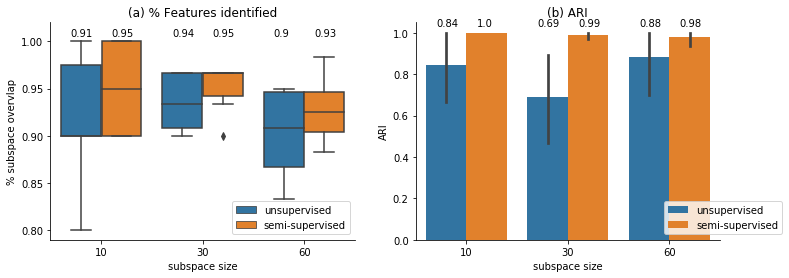

In [6]:
plt.figure(figsize = (12,4))
ax = plt.subplot(121)
means = df.groupby(["subspace size", "mode"]).mean().unstack(1).T.values
sns.boxplot(x = "subspace size", y = "values", hue = "mode",  data = df, ax = ax)
plt.ylabel("% subspace overvlap")
sns.despine()
ylim = ax.get_ylim()
plt.ylim((ylim[0], ylim[1] + 0.01))
ax.legend(bbox_to_anchor=(1,0.2))
for i in range(len(subspace_sizes)):
    plt.text(i - 0.3, 1.005,round(means[1][i], 2))
    plt.text(i + 0.1, 1.005,round(means[0][i], 2))
plt.title("(a) % Features identified")

ax = plt.subplot(122)
means = df_ari.groupby(["subspace size", "mode"]).mean().unstack(1).T.values
sns.barplot(x = "subspace size", y = "values", hue = "mode",  data = df_ari, ax = ax)
plt.ylabel("ARI")
sns.despine()
for i in range(len(subspace_sizes)):
    plt.text(i - 0.3, 1.03,round(means[1][i], 2))
    plt.text(i + 0.1, 1.03,round(means[0][i], 2))
ax.legend(bbox_to_anchor=(0.8,0.2))
plt.title("(b) ARI")

plt.savefig("../images/discovery_vs_semi-supervised.pdf", bbox_inches='tight')